In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [2]:
data_dir = Path("../data/cropped")
assert data_dir.exists()

min: 0.075599305
max: 0.9683732


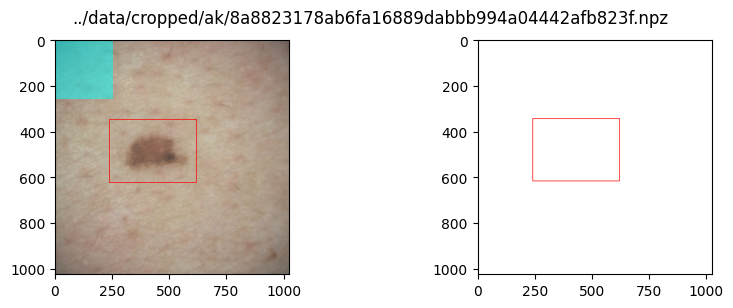

In [188]:
example_file = data_dir / "ak" / "8a8823178ab6fa16889dabbb994a04442afb823f.npz"

patch_size = 256

def plot_image_data(npz_file, dpi=72):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.1), dpi=dpi)
    fig.suptitle(str(npz_file))

    with np.load(npz_file, allow_pickle=True) as data:
        if "rgb" in data and str(data["rgb"].dtype) != "object":
            rgb = data["rgb"]
        else:
            reflectance = data["reflectance"]
            rgb = reflectance[..., 0]
        
        if "roi" in data and str(data["roi"].dtype) != "object":
            roi = data["roi"]
        else:
            roi = np.zeros((rgb.shape[0], rgb.shape[1], 3))

        print("min:", data["reflectance"][..., 0:115].min())
        print("max:", data["reflectance"][..., 0:115].max())
    
    ax1.imshow(rgb, vmin=0, vmax=1)
    ax1.add_patch(Rectangle((0, 0), patch_size, patch_size, alpha=0.5, fc="cyan"))    
    ax2.imshow(roi)
    
    mask = np.all(roi - np.array([1, 0, 0]) == np.array([0, 0, 0]), axis=2)
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.argmax(rows), mask.shape[0] - 1 - np.argmax(np.flipud(rows))
    cmin, cmax = np.argmax(cols), mask.shape[1] - 1 - np.argmax(np.flipud(cols))
    
    ax1.add_patch(Rectangle((cmin, rmin), cmax - cmin, rmax - rmin, fill=False, lw=0.5, ec="red"))    

plot_image_data(example_file, dpi=100)

<ipython-input-126-7cbd8eb05bd3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.1), dpi=dpi)


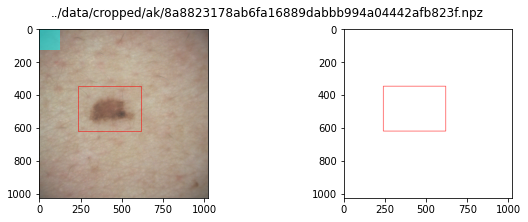

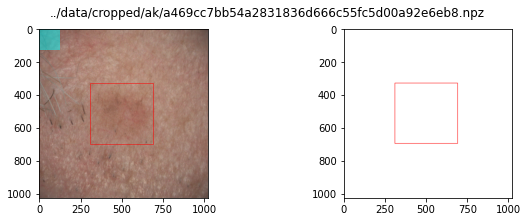

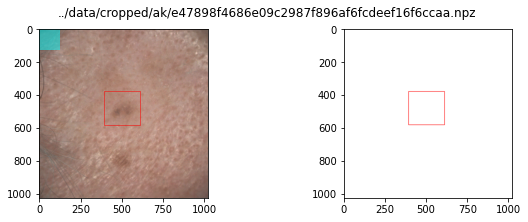

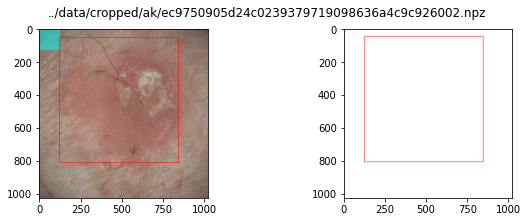

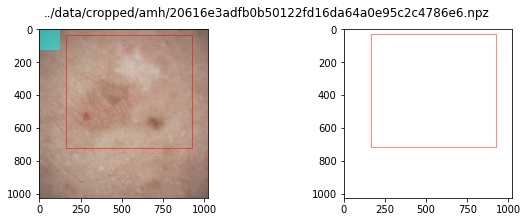

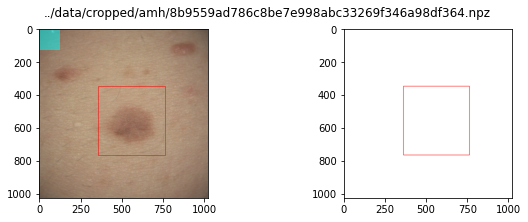

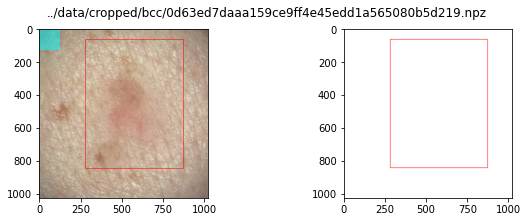

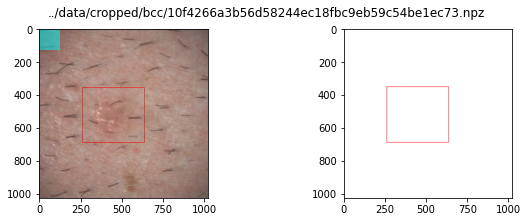

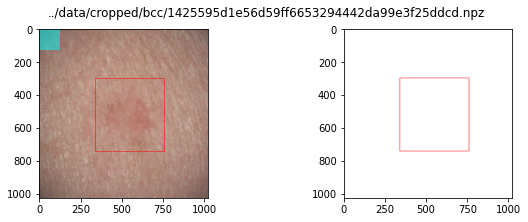

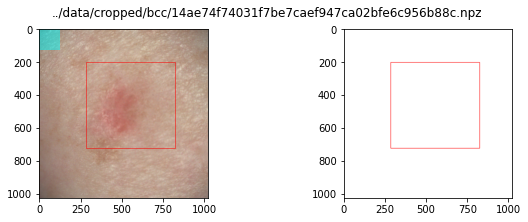

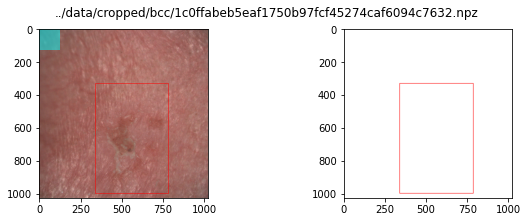

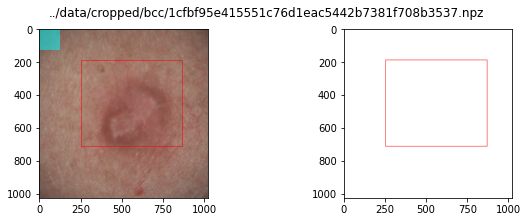

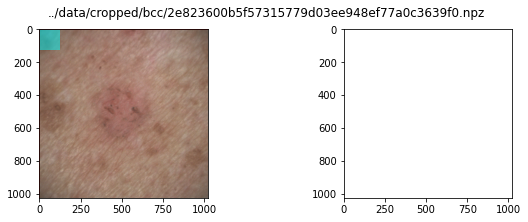

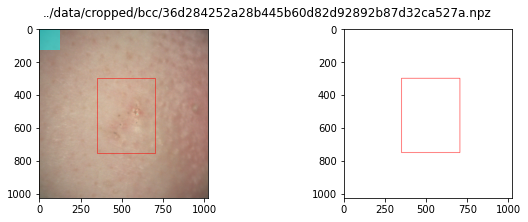

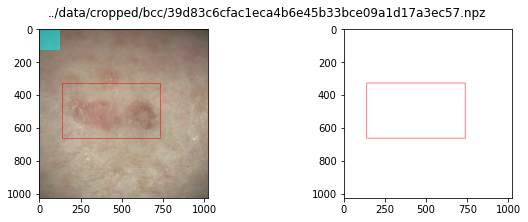

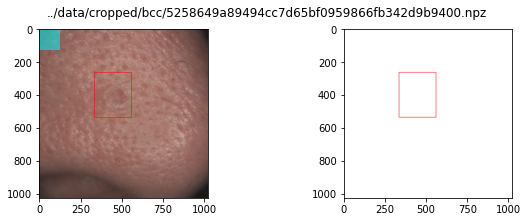

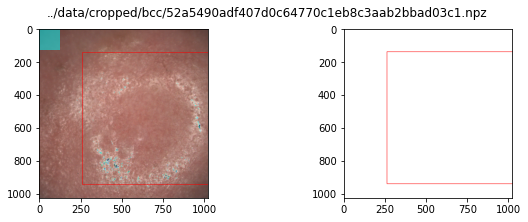

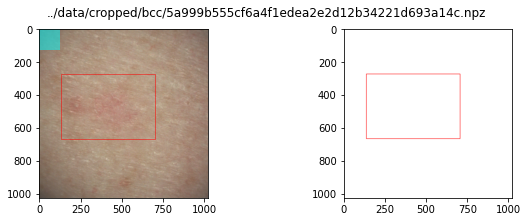

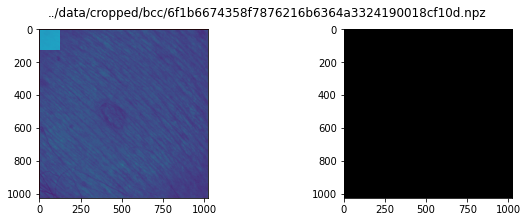

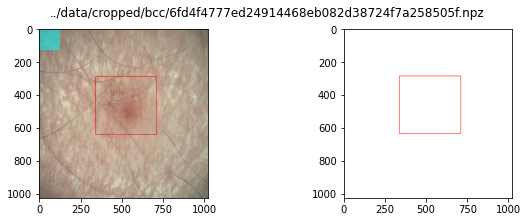

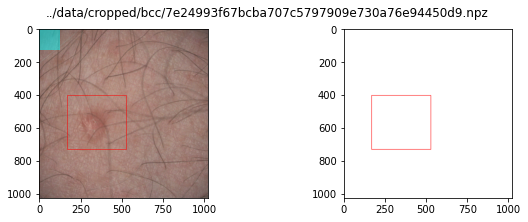

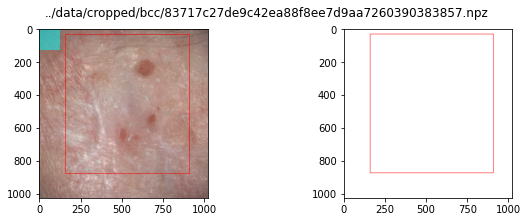

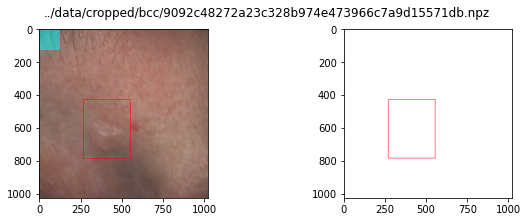

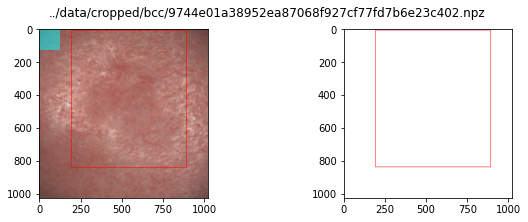

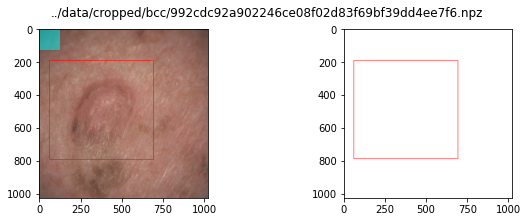

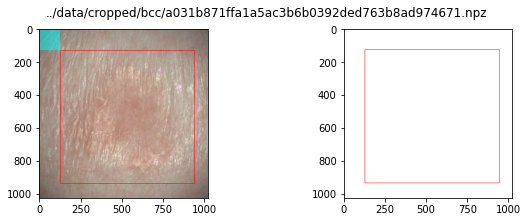

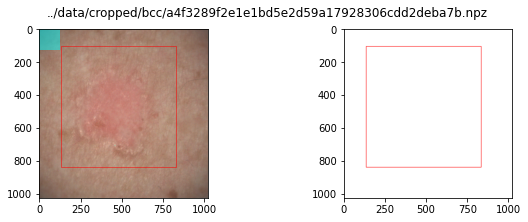

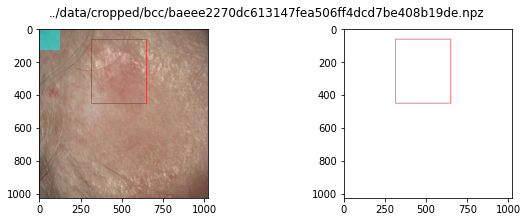

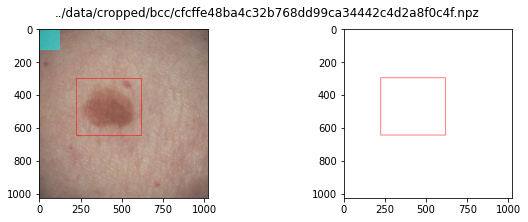

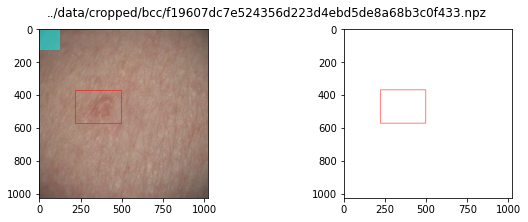

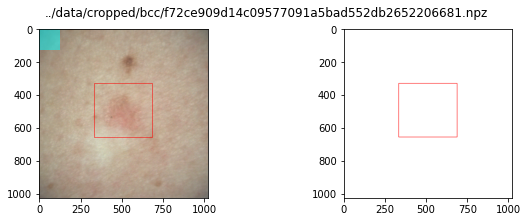

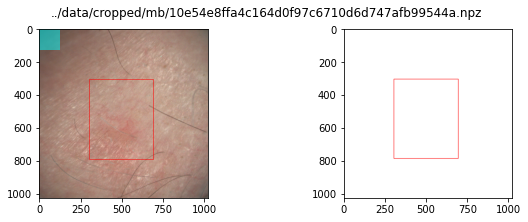

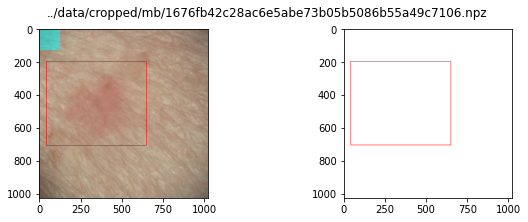

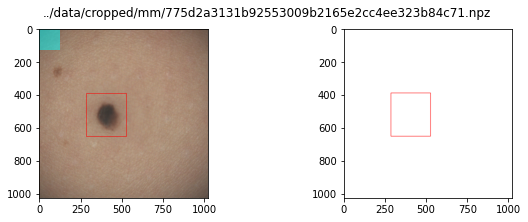

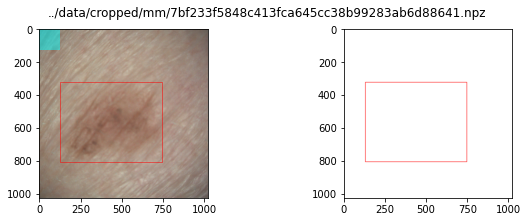

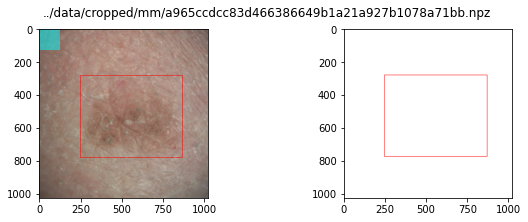

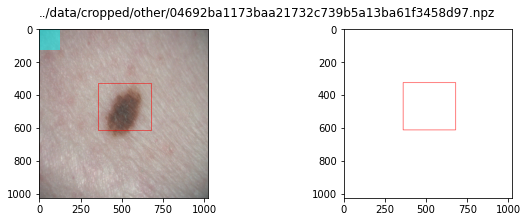

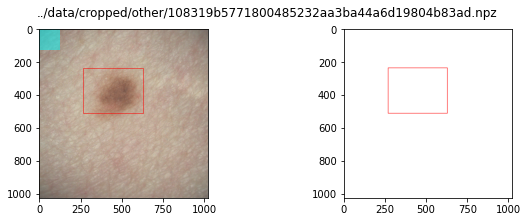

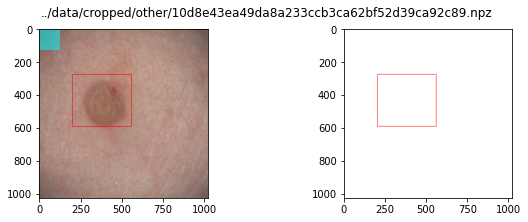

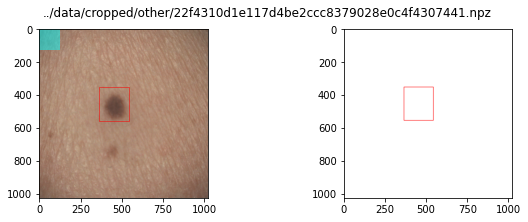

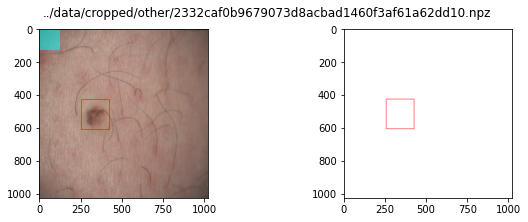

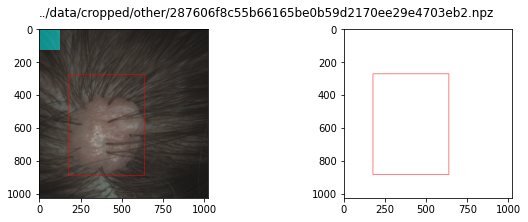

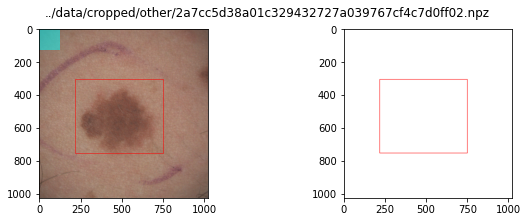

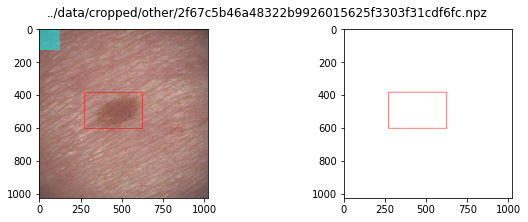

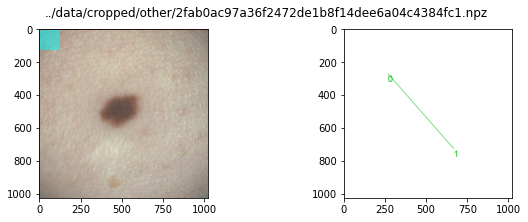

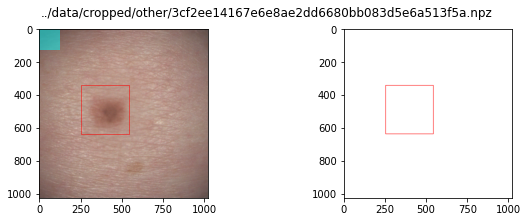

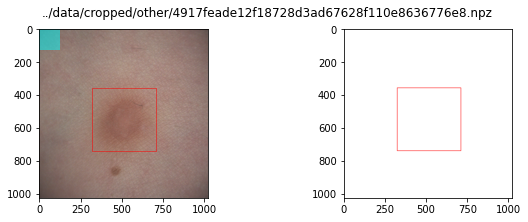

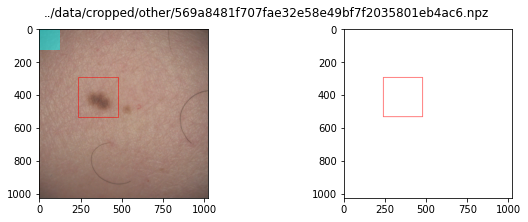

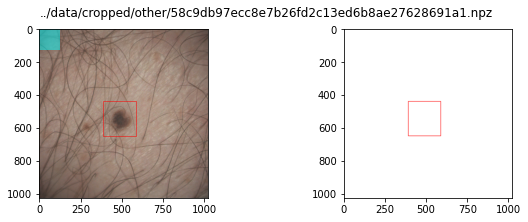

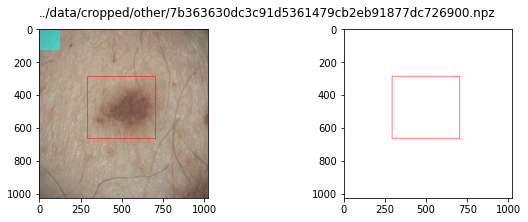

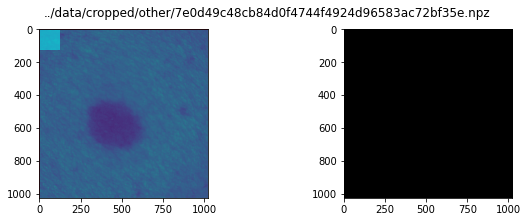

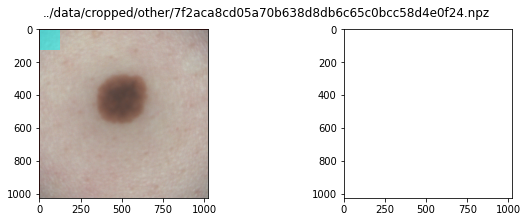

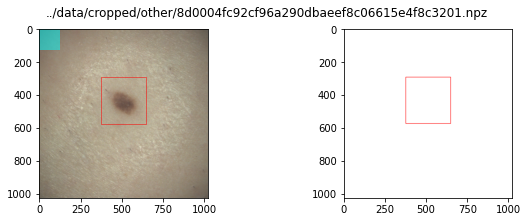

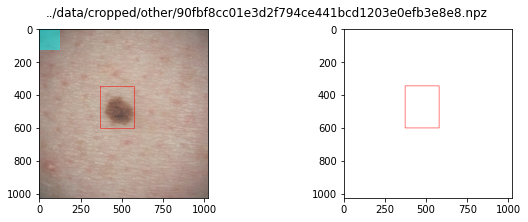

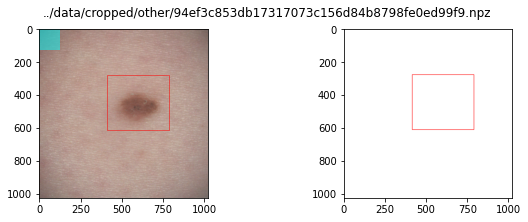

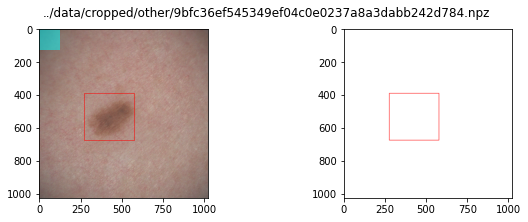

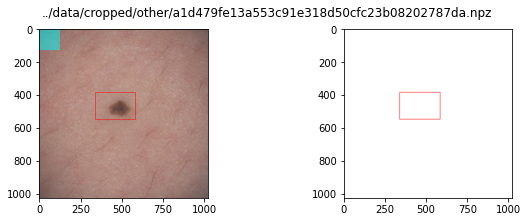

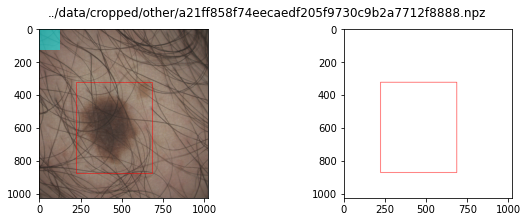

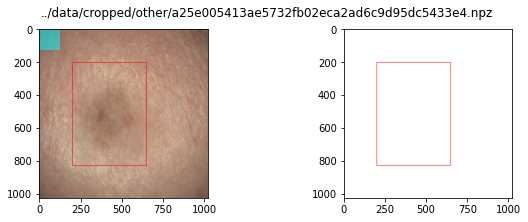

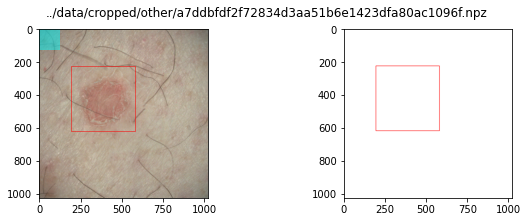

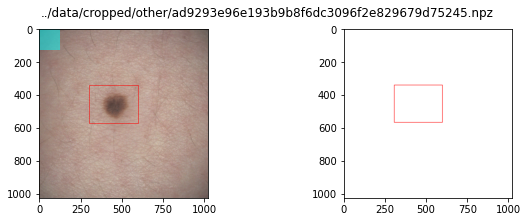

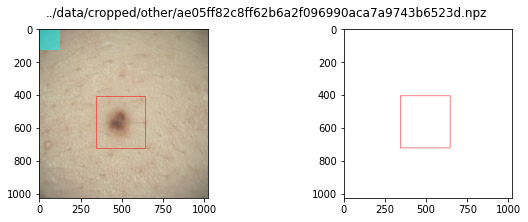

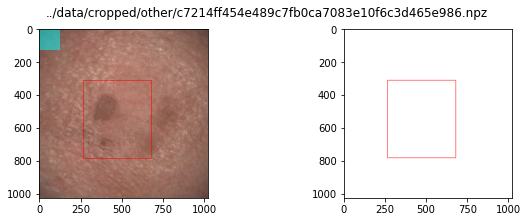

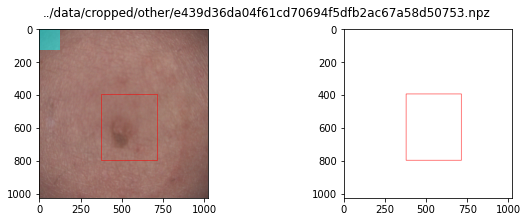

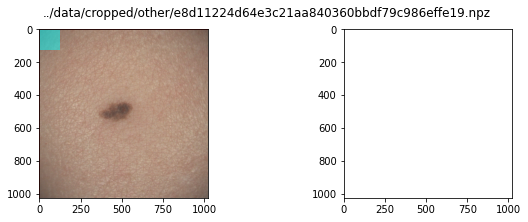

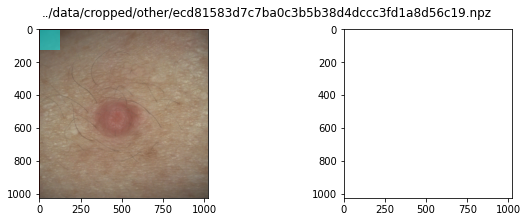

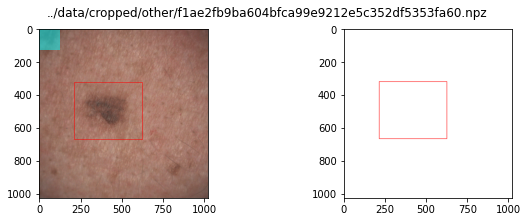

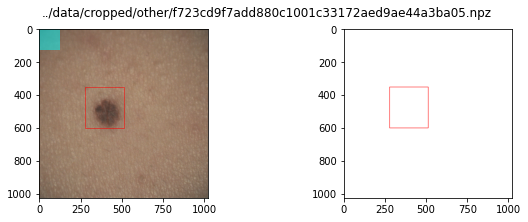

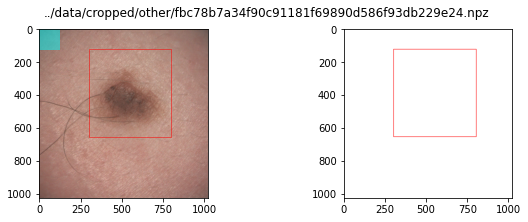

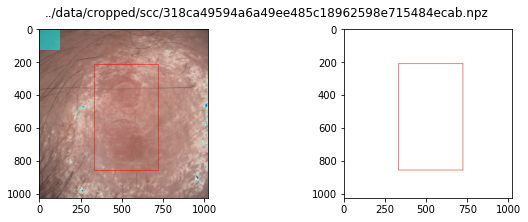

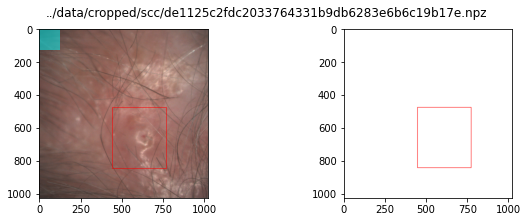

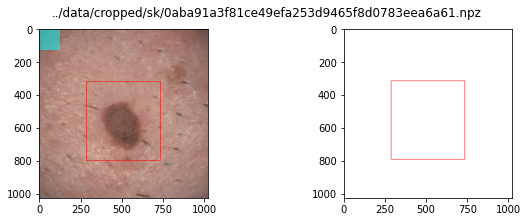

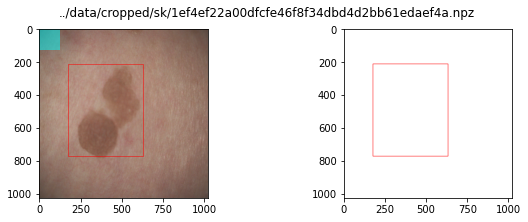

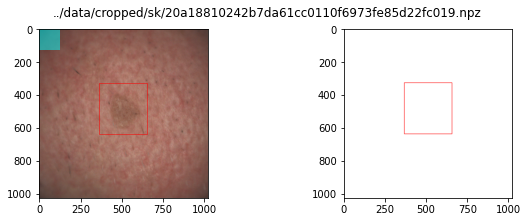

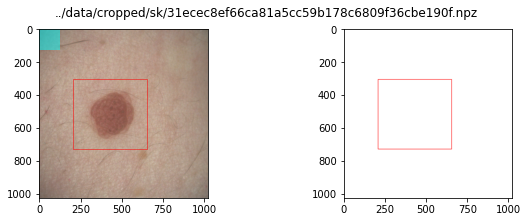

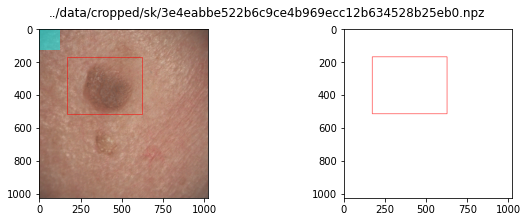

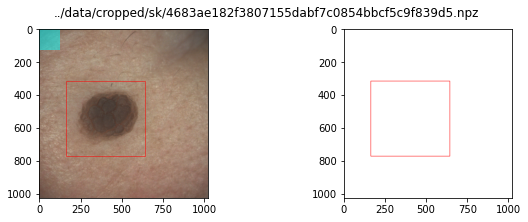

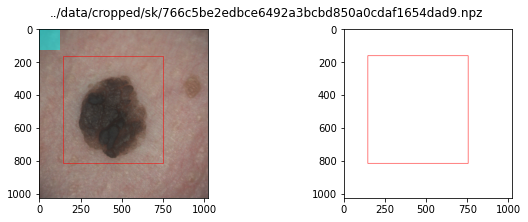

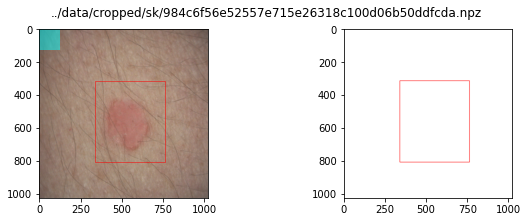

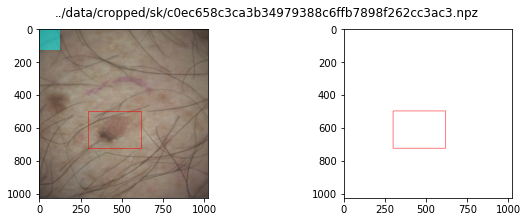

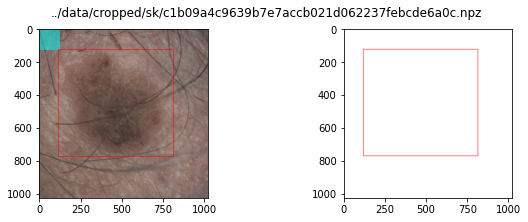

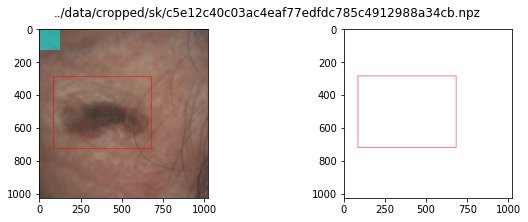

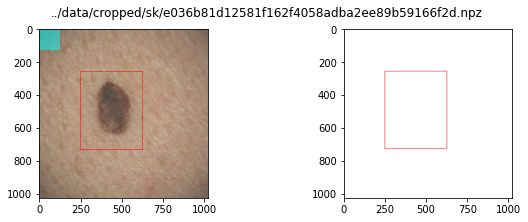

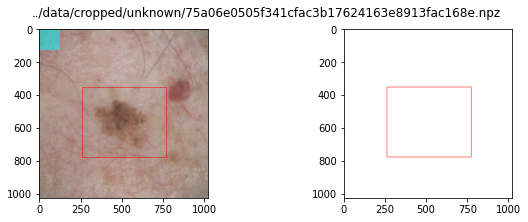

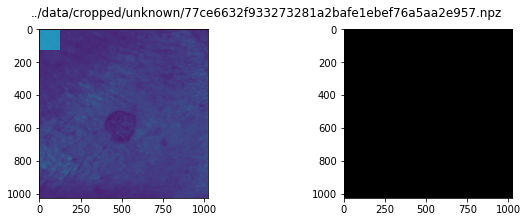

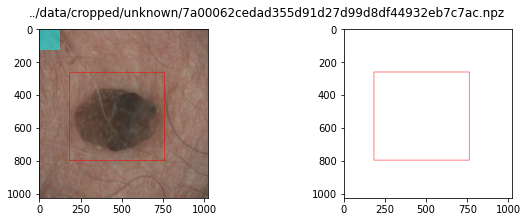

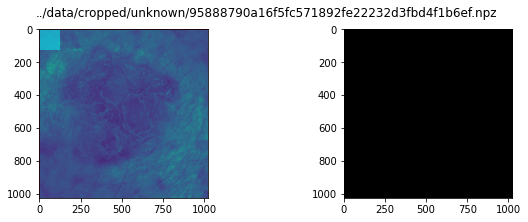

In [127]:
for i, npz_file in enumerate(sorted(data_dir.rglob("*.npz"))):
    plot_image_data(npz_file)

In [68]:
# a = np.array([[[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6]],] * 4)
a = np.array([[[1, 2, 3], [2, 3, 4], [1, 2, 3], [4, 5, 6]],] * 4)
a[3, 0] = np.array([5, 5, 5])
print(a.shape)
print(a[..., 0])
print(a[..., 1])
print(a[..., 2])

(4, 4, 3)
[[1 2 1 4]
 [1 2 1 4]
 [1 2 1 4]
 [5 2 1 4]]
[[2 3 2 5]
 [2 3 2 5]
 [2 3 2 5]
 [5 3 2 5]]
[[3 4 3 6]
 [3 4 3 6]
 [3 4 3 6]
 [5 4 3 6]]


In [73]:
b = np.all(a - np.array([7, 3, 4]) == np.array([0, 0, 0]), axis=2)
print(b)
print(b.shape)
print("*" * 42)

rows = np.any(b, axis=1)
print(rows)
cols = np.any(b, axis=0)
print(cols)
rmin, rmax = np.argmax(rows), b.shape[0] - 1 - np.argmax(np.flipud(rows))
print(rmin, rmax)
cmin, cmax = np.argmax(cols), b.shape[1] - 1 - np.argmax(np.flipud(cols))
print(cmin, cmax)

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
(4, 4)
******************************************
[False False False False]
[False False False False]
0 3
0 3


In [130]:
output_dir = Path("../output/patches")
output_dir.mkdir(parents=True, exist_ok=True)

In [172]:
def in_roi(x, y, xmin, xmax, ymin, ymax, patch_size):
    if xmin == xmax or ymin == ymax:
        return False
    
    if (x >= xmin and x <= xmax) or (x + patch_size >= xmin and x + patch_size <= xmax):
        if (y >= ymin and y <= ymax) or (y + patch_size >= ymin and y + patch_size <= ymax):
            return True
    
    return False

assert in_roi(0, 0, xmin=0, xmax=0, ymin=0, ymax=1, patch_size=1) == False
assert in_roi(0, 1, xmin=0, xmax=0, ymin=0, ymax=1, patch_size=1) == False
assert in_roi(0, 1, xmin=0, xmax=0, ymin=1, ymax=2, patch_size=1) == False
assert in_roi(0, 0, xmin=0, xmax=1, ymin=0, ymax=2, patch_size=1) == True
assert in_roi(0, 0, xmin=0, xmax=1, ymin=0, ymax=1, patch_size=1) == True
assert in_roi(0, 2, xmin=0, xmax=1, ymin=0, ymax=1, patch_size=1) == False
assert in_roi(2, 2, xmin=0, xmax=3, ymin=1, ymax=4, patch_size=4) == True
assert in_roi(4, 4, xmin=0, xmax=3, ymin=1, ymax=4, patch_size=4) == False

In [190]:
def extract_patches(npz_file, patch_sizes=[64, 128, 256]):
    print(npz_file)

    short_name = npz_file.name[:7]
    
    with np.load(npz_file, allow_pickle=True) as data:
        reflectance = data["reflectance"]
        image_size = reflectance.shape[0]
        assert image_size == reflectance.shape[1]

        if "roi" in data and str(data["roi"].dtype) != "object":
            roi = data["roi"]
        else:
            roi = np.zeros((image_size, image_size, 3))

    mask = np.all(roi - np.array([1, 0, 0]) == np.array([0, 0, 0]), axis=2)
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    ymin, ymax = np.argmax(rows), mask.shape[0] - 1 - np.argmax(np.flipud(rows))
    xmin, xmax = np.argmax(cols), mask.shape[1] - 1 - np.argmax(np.flipud(cols))

    for patch_size in patch_sizes:
        patch_dir = output_dir / str(patch_size)
        patch_dir.mkdir(parents=True, exist_ok=True)

        for yi, y in enumerate(range(0, image_size, patch_size)):
            row_slice = slice(y, y + patch_size)
            for xi, x in enumerate(range(0, image_size, patch_size)):
                col_slice = slice(x, x + patch_size)
                
                patch_name = f"{short_name}--{xi}-{yi}"
                if in_roi(x, y, xmin, xmax, ymin, ymax, patch_size):
                    patch_name += "--roi"

                patch_file = patch_dir / npz_file.parent.name / patch_name
                patch_file.parent.mkdir(parents=True, exist_ok=True)
                
                patch = reflectance[row_slice, col_slice]
                np.save(patch_file, patch, allow_pickle=False)

extract_patches(example_file)

../data/cropped/ak/8a8823178ab6fa16889dabbb994a04442afb823f.npz


In [191]:
for i, npz_file in enumerate(sorted(data_dir.rglob("*.npz"))):
    extract_patches(npz_file, patch_sizes=[32, 64, 128, 256])

../data/cropped/ak/8a8823178ab6fa16889dabbb994a04442afb823f.npz
../data/cropped/ak/a469cc7bb54a2831836d666c55fc5d00a92e6eb8.npz
../data/cropped/ak/e47898f4686e09c2987f896af6fcdeef16f6ccaa.npz
../data/cropped/ak/ec9750905d24c0239379719098636a4c9c926002.npz
../data/cropped/amh/20616e3adfb0b50122fd16da64a0e95c2c4786e6.npz
../data/cropped/amh/8b9559ad786c8be7e998abc33269f346a98df364.npz
../data/cropped/bcc/0d63ed7daaa159ce9ff4e45edd1a565080b5d219.npz
../data/cropped/bcc/10f4266a3b56d58244ec18fbc9eb59c54be1ec73.npz
../data/cropped/bcc/1425595d1e56d59ff6653294442da99e3f25ddcd.npz
../data/cropped/bcc/14ae74f74031f7be7caef947ca02bfe6c956b88c.npz
../data/cropped/bcc/1c0ffabeb5eaf1750b97fcf45274caf6094c7632.npz
../data/cropped/bcc/1cfbf95e415551c76d1eac5442b7381f708b3537.npz
../data/cropped/bcc/2e823600b5f57315779d03ee948ef77a0c3639f0.npz
../data/cropped/bcc/36d284252a28b445b60d82d92892b87d32ca527a.npz
../data/cropped/bcc/39d83c6cfac1eca4b6e45b33bce09a1d17a3ec57.npz
../data/cropped/bcc/5258649a8